In [8]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL_ORIG = 'grid search'
ALGORITHM_DETAIL = 'grid search'
VERSION = '05'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [9]:
if False:
    # Use scikit-learn to grid search the batch size and epochs
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import GridSearchCV
    from keras.models import Sequential
    from keras.layers import Dense
    from scikeras.wrappers import KerasClassifier, KerasRegressor


    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(12, input_shape=(8,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


    # fix random seed for reproducibility
    seed = 7
    tf.random.set_seed(seed)
    # load dataset
    dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
    # split into input (X) and output (Y) variables
    X = dataset[:, 0:8]
    Y = dataset[:, 8]
    # create model
    model = KerasRegressor(model=create_model, verbose=0)
    # define the grid search parameters
    batch_size = [10, 20]  #, 40, 60, 80, 100]
    epochs = [10]  #, 50, 100]
    batch_size = [10, 20]
    epochs = [10, 20]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [10]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf

from tensorflow import keras
from keras import layers

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        #layers.Dense(132, activation='relu'),
        #layers.Dense(132, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


def create_model():
    # create model
    model = Sequential()
    # model.add(Dense(12, input_shape=(8,), activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
    return model


normalizer = tf.keras.layers.Normalization(axis=-1)

dnn_model = build_and_compile_model(normalizer)

model = KerasRegressor(model=create_model, verbose=1)

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    #('model', dnn_model)
    ('model', model)
])
model

2.10.0


KerasRegressor(
	model=<function create_model at 0x7fd946388af0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [11]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    from functions_20221019 import set_csv_directory, get_columns

    set_csv_directory('final_split')

debug_mode = False

In [12]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [13]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    features = df[df.columns[2:]].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index



In [14]:
df, retrieval_type = get_source_dataframe()
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v05.csv
(46877, 9)


In [15]:
df

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
...,...,...,...,...,...,...,...,...,...
126179018,575000.0,2.0,1.0,0.682879,51.370651,-0.238346,0.129069,0.133926,FREEHOLD
126179672,600000.0,3.0,2.0,0.545665,51.357170,-0.074740,0.142550,0.029680,LEASEHOLD
126180107,419999.0,2.0,1.0,0.191407,51.531415,-0.052964,0.031695,0.051456,LEASEHOLD
126180704,475000.0,2.0,1.0,0.308609,51.543141,0.011498,0.043421,0.115918,LEASEHOLD


In [16]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [17]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46877 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46877 non-null  float64
 1   bedrooms             46877 non-null  float64
 2   bathrooms            46877 non-null  float64
 3   nearestStation       46877 non-null  float64
 4   location.latitude    46877 non-null  float64
 5   location.longitude   46877 non-null  float64
 6   latitude_deviation   46877 non-null  float64
 7   longitude_deviation  46877 non-null  float64
 8   tenure.tenureType    44133 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000
mean,425062.235531,1.992448,1.182115,0.440245,51.497056,-0.113270,0.064316,0.124201
std,107229.476820,0.828823,0.409907,0.350941,0.077085,0.156486,0.042575,0.095604
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.000000,0.227201,51.438866,-0.210803,0.028875,0.043560
50%,425000.000000,2.000000,1.000000,0.367989,51.499980,-0.102230,0.058595,0.098984
75%,515000.000000,3.000000,1.000000,0.559762,51.556187,-0.010345,0.094355,0.192683
max,600000.000000,7.000000,5.000000,16.168861,51.683185,0.279726,0.201403,0.393895


In [18]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46877 ==> 46877


,count,mean,std,min,25%,50%,75%,max
Price,46877.0,425062.235531,107229.476820,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46877.0,1.992448,0.828823,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46877.0,1.182115,0.409907,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46877.0,0.440245,0.350941,0.000000,0.227201,0.367989,0.559762,16.168861
location.latitude,46877.0,51.497056,0.077085,51.298317,51.438866,51.499980,51.556187,51.683185
location.longitude,46877.0,-0.113270,0.156486,-0.498315,-0.210803,-0.102230,-0.010345,0.279726
latitude_deviation,46877.0,0.064316,0.042575,0.000000,0.028875,0.058595,0.094355,0.201403
longitude_deviation,46877.0,0.124201,0.095604,0.000000,0.043560,0.098984,0.192683,0.393895


In [19]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [20]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46877 ==> 44133


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000
mean,425217.021141,1.990959,1.181384,0.440008,51.496719,-0.113106,0.064543,0.123698
std,107205.633151,0.827606,0.408961,0.350783,0.077267,0.155860,0.042584,0.095217
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.000000,0.227574,51.438306,-0.210640,0.029023,0.043552
50%,425000.000000,2.000000,1.000000,0.368397,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.000000,0.559534,51.556384,-0.010855,0.094620,0.191725
max,600000.000000,7.000000,5.000000,16.168861,51.683185,0.279726,0.201403,0.393895


In [21]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(39719, 11) (4414, 11) (39719, 1) (4414, 1) (39719, 1) (4414, 1) (39719, 1) (4414, 1)


In [22]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [23]:
from time import time

#pipe.fit(X_train, y_train)

if False:
    model = dnn_model
#model.fit(X_train, y_train)
if False:
    model.get_params()

In [24]:
X_train

array([[3.        , 1.        , 0.27735721, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.36797073, ..., 0.        , 1.        ,
        0.        ],
       [2.        , 2.        , 0.41456435, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [3.        , 2.        , 0.4845893 , ..., 1.        , 0.        ,
        0.        ],
       [2.        , 1.        , 0.45486169, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.2095445 , ..., 0.        , 0.        ,
        1.        ]])

In [25]:
if True:

    # Use scikit-learn to grid search the batch size and epochs
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import GridSearchCV
    from keras.models import Sequential
    from keras.layers import Dense
    from scikeras.wrappers import KerasClassifier


    # Function to create model, required for KerasClassifier
    def create_model():
        global ALGORITHM_DETAIL, ALGORITHM_DETAIL_ORIG

        # create model
        if False:
            model = Sequential()
            #model.add(Dense(12, input_shape=(8,), activation='relu'))
            #model.add(Dense(12, input_shape=(9,), activation='relu'))
            model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        elif False:
            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL += ' [input_dense12, normaliser, dense1]'

            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = Sequential()
            model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
            #model.add(normalizer)
            model.add(Dense(1, activation='sigmoid'))

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model

        elif True:
            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL += ' [input64, norm, dense64^6, dense1]'

            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = Sequential()
            model.add(Dense(64, input_shape=(len(X_train[0]),), activation='relu'))
            model.add(normalizer)
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1))

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model

        else:
            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = keras.Sequential([
                normalizer,
                layers.Dense(64, activation='relu'),
                layers.Dense(64, activation='relu'),
                #layers.Dense(132, activation='relu'),
                #layers.Dense(132, activation='relu'),
                layers.Dense(1)
            ])

            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL+= ' [normaliser, dense64, dense64]'

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model


# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 100]  #, 40, 60, 80, 100]
epochs = [100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=2, verbose=5)
#grid_result = grid.fit(X, Y)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2022-10-19 13:43:12.667861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 13:43:12.806653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 13:43:13.043594: I tensorflow/core/plat

[CV 1/2] END ........batch_size=100, epochs=100;, score=0.484 total time= 3.0min
[CV 2/2] END ........batch_size=100, epochs=100;, score=0.451 total time= 3.0min
[CV 2/2] END .........batch_size=10, epochs=100;, score=0.518 total time=13.9min
[CV 1/2] END .........batch_size=10, epochs=100;, score=0.476 total time=14.2min
Best: 0.496730 using {'epochs': 100, 'batch_size': 10}
0.496730 (0.021085) with: {'epochs': 100, 'batch_size': 10}
0.467181 (0.016555) with: {'epochs': 100, 'batch_size': 100}


In [26]:
pipe = grid_result.best_estimator_
timings = []

if False:
    t0 = time()
    pipe.fit(X_train, y_train)
    timings.append(time() - t0)

    print(timings)
else:
    timings = [999]

average_time = sum(timings) / len(timings)
print(average_time)


999.0


In [27]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'epochs': 100, 'batch_size': 10}
0.497 (+/-0.042) for {'epochs': 100, 'batch_size': 10}
0.467 (+/-0.033) for {'epochs': 100, 'batch_size': 100}
Best Index:  0
Best Score:  0.49673020105902116
Best Params:  {'epochs': 100, 'batch_size': 10}


In [28]:
pipe

KerasRegressor(
	model=<function create_model at 0x7fd9199dc8b0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [29]:
y_pred = pipe.predict(X_test)
#y_pred = pipe.evaluate(X_test, y_test, verbose=0)
y_pred

array([[526410.2],
       [401507.7],
       [401204.3],
       ...,
       [542926.8],
       [526466.9],
       [456802.4]], dtype=float32)

In [30]:
pipe

KerasRegressor(
	model=<function create_model at 0x7fd9199dc8b0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy 0.5447438374726965
Mean Absolute Error Accuracy 55885.640490484824
Mean Squared Error Accuracy 5064702159.344852
Root Mean Squared Error 71166.72086969338


In [32]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [33]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
122562932.0,550000.0,526410.18750,23589.81250,4.289057,4.481261
117089147.0,375000.0,401507.68750,26507.68750,7.068717,6.602037
123446663.0,475000.0,401204.31250,73795.68750,15.535934,18.393543
124867340.0,450000.0,381424.18750,68575.81250,15.239069,17.978884
121165313.0,325000.0,393296.43750,68296.43750,21.014288,17.365130
...,...,...,...,...,...
126115436.0,425000.0,412527.00000,12473.00000,2.934824,3.023560
123739259.0,235000.0,358439.50000,123439.50000,52.527447,34.438029
68620869.0,475000.0,542926.81250,67926.81250,14.300382,12.511228


In [34]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType


In [35]:
score = pipe.score(X_test, y_test)
score

0.5447438374726965

In [36]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.5447438374726965

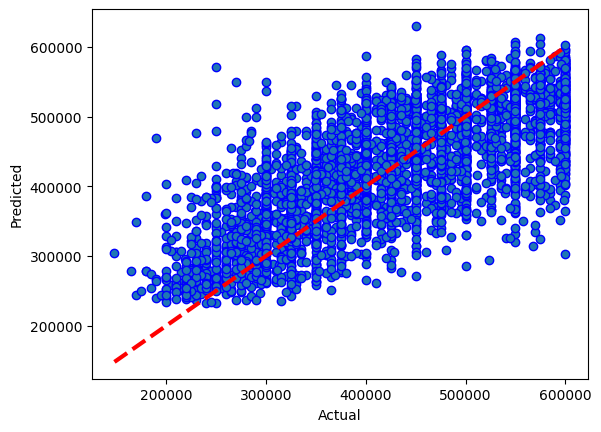

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [40]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(saved_results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = saved_results_json[key]['date']
        first_run_date = saved_results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = saved_results_json[key]['Score']
        max_params = saved_results_json[key]['params']
        max_score = saved_results_json[key]['max score']
        max_params = saved_results_json[key]['max params']
    except:
        pass

    results['first run'] = first_run_date
    if key not in saved_results_json:
        new_results['max params'] = new_results['params']
        new_results['max score'] = new_results['Score']
        new_results['suboptimal'] = 'pending'
    elif max_score > saved_results_json[key]['Score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == saved_results_json[key]['Score']:
        if saved_results_json[key]['params'] != new_results['params']:
            new_results['max params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['max params'] = saved_results_json[key]['params']
            new_results['max score'] = saved_results_json[key]['Score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['max params'] = saved_results_json[key]['params']
        new_results['max score'] = saved_results_json[key]['Score']
        new_results['suboptimal'] = 'pending'

    saved_results_json[key] = new_results

    results_filename = '../../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(saved_results_json, indent=4, sort_keys=True))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.5447438374726965,
 'R square Accuracy': 0.5447438374726965,
 'Mean Absolute Error Accuracy': 55885.640490484824,
 'Mean Squared Error Accuracy': 5064702159.344852,
 'Root Mean Squared Error': 71166.72086969338,
 'Training Time': 999.0,
 'random_state': 101,
 'date': '2022-10-19 14:27:35.067307',
 'params': {'epochs': 100, 'batch_size': 10},
 'first run': '2022-10-19 01:41:10.125181',
 'max params': {'batch_size': 10, 'epochs': 100},
 'max score': 0.5447438374726965,
 'suboptimal': 'pending'}

In [41]:
results
import pickle

# try:
#     model = pickle.load(open(f'model_{ALGORITHM}.pkl', 'rb'))
#     # raise ValueError
# except:
#     model = build_model(ALGORITHM, drop_nulls=~include_nulls)
#     with open(f'models/model_{ALGORITHM}.pkl', 'wb') as f:
#         pickle.dump(model, f)


with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}.pkl', 'wb') as f:
    pickle.dump(grid_result.best_estimator_, f)

INFO:tensorflow:Assets written to: ram:///tmp/tmpuvdf4eza/assets
